<a href="https://colab.research.google.com/github/berthine/SIAM-Summer-School/blob/main/SIAM2021_Linear_Reg_(long).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical: Introduction to linear regression using Tensorflow (long approach)
(19/July/2021)

### 2021 Gene Golub SIAM Summer School 
https://sites.google.com/aims.ac.za/g2s3/home 

Instructor

<font color="green">***Dr. Emmanuel Dufourq*** 

www.emmanueldufourq.com

edufourq (['@']) gmail.com

***African Institute for Mathematical Sciences***

***Stellenbosch University***

***2021***


Material adapted from:

https://d2l.ai/chapter_linear-networks/linear-regression-scratch.html

https://www.tensorflow.org/guide/basic_training_loops

## <font color="green"> Learning outcomes:

* initialising a ```tf.Variable`` using ```tf.random.normal```

* how to define a loss function

* how to implement a training loop

* how to create a model using ```tf.Module```

## <font color="green">Data information:

* Features: one real-valued feature

* Output: one real valued label

## <font color="green">Tasks for participants (boolean)?

* No, follow along and make your own modifications and make sure you understand


Solving a machine learning problem usually consists of the following steps:

 - Obtain training data.
 - Define the model.
 - Define a loss function.
 - Run through the training data, calculating loss from the ideal value
 - Calculate gradients for that loss and use an *optimizer* to adjust the variables to fit the data.
 - Evaluate your results.

For illustration purposes, in this guide you'll develop a simple linear model, $f(x) = x * W + b$, which has two variables: $W$ (weights) and $b$ (bias).

This notebook is built with the above points in time and we will spend a bit of effort with the Tensorflow details. In future practicals we will only implement the "concise"/shorter versions.

In [ ]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

## First we generate some data

In [ ]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# A vector of random x values
x = tf.random.normal(shape=[NUM_EXAMPLES])

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = x * TRUE_W + TRUE_B + noise

features = x
labels = y

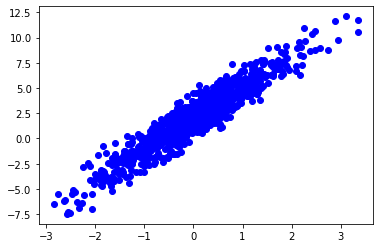

In [ ]:
plt.scatter(x, y, c="b")
plt.show()

Recall that training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. 

Each minibatch consists of a tuple of features and labels.

The function below creates an iterator which can generate mini-batches of X-y pairs



In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    
    # The examples are read at random, in no particular order
    random.shuffle(indices)

    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])

        # Return a tuple of features and labels
        yield tf.gather(features, j), tf.gather(labels, j)

Let's take a look at a mini batch

In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print ('mini batch X')
    print(X)
    print ('\nmini batch Y')
    print (y)
    break

mini batch X
tf.Tensor(
[ 0.98331404  0.06941333 -0.04209832  0.4019146  -1.4332167  -0.76408404
 -0.85331774  0.88181895 -0.6238408  -0.74457437], shape=(10,), dtype=float32)

mini batch Y
tf.Tensor(
[ 5.1743126   2.6530383   2.9406776   3.7471578  -2.288357    0.39210385
  0.29372722  4.412133   -2.3663294   0.15522236], shape=(10,), dtype=float32)


## Define the model part a) initialise parameters

Let's create a weight and a bias that we would like to optimise.

Use ```tf.Variable``` to represent all weights in a model. A ```tf.Variable``` stores a value and provides this in tensor form as needed. 

API: https://www.tensorflow.org/api_docs/python/tf/Variable

Weight, w

In [ ]:
w = tf.Variable(tf.random.normal(shape=[1], mean=0, stddev=0.01),
                trainable=True)

In [ ]:
w

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.00780163], dtype=float32)>

bias, b

In [ ]:
b = tf.Variable(tf.zeros(1), trainable=True)

In [ ]:
b

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

After initializing our parameters, our next task is to update them until they fit our data sufficiently well. Each update requires taking the gradient of our loss function with respect to the parameters.

## Define the model part b) create the actual model

Next, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the linear model, we simply take the matrix-vector dot product of the input features X and the model weights w, and add the offset b to each example. 

Here let's write the model using ```tf.Module``` and embrace some object-oriented programming.

API https://www.tensorflow.org/api_docs/python/tf/Module?hl=en

In [ ]:
class MyFirstModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # Let's re-define our variables here
    self.w = tf.Variable(tf.random.normal(shape=[1], mean=0, stddev=0.01), trainable=True)
    self.b = tf.Variable(tf.zeros(1), trainable=True)

  def __call__(self, x):
    return (x * self.w) + self.b

In [ ]:
linear_reg = MyFirstModel()

In [ ]:
linear_reg.variables

(<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.00331406], dtype=float32)>)

In [ ]:
linear_reg(3.0)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00994217], dtype=float32)>

Plot the predictions before the optimisation process

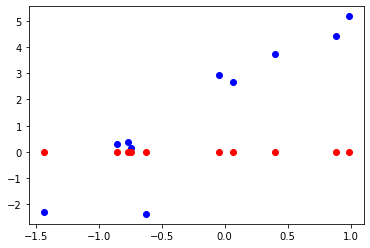

In [ ]:
plt.scatter(X, y, c="b")
plt.scatter(X, linear_reg(X), c="r")
plt.show()

## Define the loss function

reduce_mean : https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean?hl=en

squre : https://www.tensorflow.org/api_docs/python/tf/math/square?hl=en

In [ ]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.math.square(target_y - predicted_y))

## Training

In [ ]:
# Define a learning rate
lr = 0.01

# Define number of epochs
num_epochs = 30

# We will keep track of the weights so we can plot them over the epochs
Ws, bs = [], []

# Iterate for a number of epochs
for epoch in range(num_epochs):

    # In each epoch generate batches of training data
    for X, y in data_iter(batch_size, features, labels):

        # Trainable variables are automatically tracked by GradientTape
        with tf.GradientTape() as g:
            l = loss(linear_reg(X), y)  # Minibatch loss in `X` and `y`

        # Compute gradient on l with respect to [`w`, `b`] which are on
        # inside the model (self.w and self.b)
        dw, db = g.gradient(l, [linear_reg.w, linear_reg.b])

        # Subtract the gradient scaled by the learning rate
        linear_reg.w.assign_sub((lr * dw)/batch_size)
        linear_reg.b.assign_sub((lr * db)/batch_size)

    # Keep track of the weights so we can make a nice plot
    Ws.append(linear_reg.w.numpy())
    bs.append(linear_reg.b.numpy())

    # Compute this epochs's training loss
    train_l = loss(linear_reg(features), labels)

    # Print to the screen
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}, w: {linear_reg.w.numpy()}, b: {linear_reg.b.numpy()}')

epoch 1, loss 6.947443, w: [0.50435585], b: [0.35064498]
epoch 2, loss 7.294414, w: [0.9223909], b: [0.63905233]
epoch 3, loss 3.140060, w: [1.2712542], b: [0.8766365]
epoch 4, loss 3.481427, w: [1.5622636], b: [1.0724792]
epoch 5, loss 1.877817, w: [1.8053612], b: [1.2343408]
epoch 6, loss 1.466125, w: [2.0081193], b: [1.3679719]
epoch 7, loss 1.433790, w: [2.1767917], b: [1.478495]
epoch 8, loss 1.423829, w: [2.317609], b: [1.5684817]
epoch 9, loss 1.856348, w: [2.4353871], b: [1.6433233]
epoch 10, loss 1.059382, w: [2.5332282], b: [1.704873]
epoch 11, loss 0.364805, w: [2.6141853], b: [1.7568412]
epoch 12, loss 1.616191, w: [2.681855], b: [1.7989444]
epoch 13, loss 1.209385, w: [2.738776], b: [1.8341955]
epoch 14, loss 0.305315, w: [2.7859726], b: [1.8631991]
epoch 15, loss 1.051127, w: [2.82569], b: [1.8869275]
epoch 16, loss 1.235542, w: [2.8588486], b: [1.906573]
epoch 17, loss 1.848067, w: [2.885967], b: [1.9229707]
epoch 18, loss 0.878257, w: [2.909348], b: [1.9369556]
epoch 19

## Evaluate

Plot the change in weights compared to the true ones

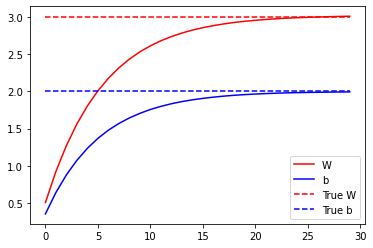

In [ ]:
plt.plot(range(num_epochs), Ws, "r",
         range(num_epochs), bs, "b")

plt.plot([TRUE_W] * len(range(num_epochs)), "r--",
         [TRUE_B] * len(range(num_epochs)), "b--")

plt.legend(["W", "b", "True W", "True b"])
plt.show()